In [1]:
import torch
# from transformers import MT5ForConditionalGeneration, MT5Config, MT5EncoderModel, MT5Tokenizer, Trainer, TrainingArguments

# from transformers_custom import MT5ForConditionalGenerationWithLatentSpace
# from progeny_tokenizer import TAPETokenizer

from transformers_custom import T5ForConditionalGenerationWithLatentSpace, T5Tokenizer, T5Config
import numpy as np
import math
import random
import scipy
import scipy.stats
import time
import pandas as pd
from torch.utils.data import DataLoader, RandomSampler, Dataset, BatchSampler
import typing
from pathlib import Path
import argparse

from tqdm import tqdm, trange
import shutil

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

import os

import matplotlib.pyplot as plt

In [2]:
train_omitted_labels = [3, 4]

In [3]:
tokenizer_pretrained_dir = "t5-base"
seed = 30
data_dir = "data/sst"
pretrained_dir = "/export/share/alvinchan/models/SST5/congen/SST5_leave34out_t5base_clspool_waeDeterencStart4kstep512dim_cyccon1Start4kstep_lre-04_25ep/"

In [4]:
# src_json = '/export/share/bkrause/progen/progeny/t5_base_uniref_bfd50/config.json'
# shutil.copy(src_json, pretrained_dir)

In [5]:
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# output_dir = Path("/export/share/alvinchan/models/SST5/congen/analysis/SST5_leave34out_t5base_clspool_waeDeterencStart4kstep512dim_cyccon1Start4kstep_lre-04_25ep/")
# output_dir.mkdir(parents=True, exist_ok=True)

# tokenizer = TAPETokenizer(vocab="progeny")
tokenizer = T5Tokenizer.from_pretrained(tokenizer_pretrained_dir)

device = torch.device('cuda:0')

# t5config = MT5Config.from_pretrained(pretrained_dir)


In [6]:
latent_space_args = {
    'latent_pooler': 'cls',
    'pool_enc_hidden_states_for_dec': True,
    'latent_space_type': 'wae',
    'mask_non_target_z_vector': False,
    'separate_targetattr_head': False,
    'z_tar_vector_dim': 1,
    'do_mi': False,
    'latent_size': 768,
    'wae_z_enc_type': 'deterministic',
    'separate_latent_enc': False,
    'separate_latent_dec': False,
}

model = T5ForConditionalGenerationWithLatentSpace.from_pretrained(pretrained_dir, **latent_space_args)

model.parallelize()

model_dim:  768
config.d_model:  768


# Evaluate Generator's ddG predictions

In [7]:
# train_ratio=0.9
per_device_train_batch_size = 16
per_device_eval_batch_size = 64

In [8]:
TEXT_COL, LABEL_COL = 'text', 'truth'

def read_sst5(data_dir, colnames=[LABEL_COL, TEXT_COL]):
    datasets = {}
    for t in ["train", "dev", "test"]:
        df = pd.read_csv(os.path.join(data_dir, f"sst_{t}.txt"), sep='\t', header=None, names=colnames)
        df[LABEL_COL] = df[LABEL_COL].str.replace('__label__', '')
        df[LABEL_COL] = df[LABEL_COL].astype(int)   # Categorical data type for truth labels
        df[LABEL_COL] = df[LABEL_COL] - 1  # Zero-index labels for PyTorch
        df[TEXT_COL] = df[TEXT_COL].str.replace("`", "'") # handle T5Tokenizer's inability to tokenize `, tokenizes it as <unk>
        datasets[t] = df
    return datasets


class TextDFDatasetForGen(Dataset):
    """Creates a dataset from an df file.
    Args:
        data_file (typing.Union[str, Path]): Path to pkl df file.
        in_memory (bool, optional): Whether to load the full dataset into memory.
            Default: False.
    """

    def __init__(self,
                df,
                in_memory: bool = False,
                split: str = None,
                train_ratio: float = 1,
                omitted_labels=None,
                ):
        
        if omitted_labels is not None:
            df = df.loc[~df['truth'].isin(omitted_labels)]

        if train_ratio != 1 and split != None:
            shuffled_df = df.sort_index()
            # shuffled_df = df.sample(frac=1)
            train_num_samples = int(len(shuffled_df) * train_ratio)
            if split == 'train':
                final_df = shuffled_df.iloc[:train_num_samples]
            elif split == 'valid':
                final_df = shuffled_df.iloc[train_num_samples:]
            else:
                final_df = df
        else:
            final_df = df

        self.df = final_df
        num_examples = len(final_df)
        self._num_examples = num_examples
        
        if in_memory:
            cache = [None] * num_examples
            self._cache = cache
            
        self._in_memory = in_memory

        
    def __len__(self) -> int:
        return self._num_examples

    def __getitem__(self, index: int):
        if not 0 <= index < self._num_examples:
            raise IndexError(index)

        if self._in_memory and self._cache[index] is not None:
            item = self._cache[index]
        else:
            row = self.df.iloc[index]
            item = {}
            item['sentiment_scores'] = row['truth'] 
            item['input_ids'] = row['text']
            item['labels'] = row['text']

            item['id'] = str(index)
            if self._in_memory:
                self._cache[index] = item
            
        return item

def pad_sequences(sequences: typing.Sequence, constant_value=0, dtype=None) -> np.ndarray:
    batch_size = len(sequences)
    shape = [batch_size] + np.max([seq.shape for seq in sequences], 0).tolist()

    if dtype is None:
        dtype = sequences[0].dtype

    if isinstance(sequences[0], np.ndarray):
        array = np.full(shape, constant_value, dtype=dtype)
    elif isinstance(sequences[0], torch.Tensor):
        array = torch.full(shape, constant_value, dtype=dtype)

    for arr, seq in zip(array, sequences):
        arrslice = tuple(slice(dim) for dim in seq.shape)
        arr[arrslice] = seq

    return array


class CustomTextDatasetForGenLatentSpace(Dataset):

    def __init__(self,
                df,
                tokenizer,
                split: str,
                in_memory: bool = False,
                train_ratio: float = 1,
                omitted_labels = None, # list of label to omit from dataset
                prepended_cls_token='<extra_id_0>',
                ):

        self.tokenizer = tokenizer

        if split == 'valid':
            file_prefix = 'train'
        else:
            file_prefix = split

        self.data = TextDFDatasetForGen(df, in_memory, split, train_ratio, omitted_labels=omitted_labels)
        self.omitted_labels = omitted_labels

        if prepended_cls_token is not None:
            self.prepended_cls_token_id = self.tokenizer.encode(prepended_cls_token)[0]
        else:
            self.prepended_cls_token_id = None

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int):
        item = self.data[index]
        input_ids = self.tokenizer.encode(item['input_ids'])
        labels = self.tokenizer.encode(item['labels'])


        if self.prepended_cls_token_id is not None:
            input_ids = [self.prepended_cls_token_id] + input_ids
            labels = [self.prepended_cls_token_id] + labels

        
        input_ids = np.array(input_ids, np.int64)
        labels = np.array(labels, np.int64)
        
        sentiment_scores = item['sentiment_scores']
#         print("__getitem__input_ids: ", input_ids)
#         print("__getitem__labels: ", labels)
#         print("__getitem__sentiment_scores: ", sentiment_scores)
        
#         print("__getitem__input_ids type: ", type(input_ids))
#         print("__getitem__labels type: ", type(labels))
#         print("__getitem__sentiment_scores : ", type(sentiment_scores))
        
#         np.array(token_ids, np.int64)
        return input_ids, labels, sentiment_scores

    
    def collate_fn(self, batch: typing.List[typing.Tuple[typing.Any, ...]]) -> typing.Dict[str, torch.Tensor]:
        input_ids, labels, sentiment_scores = tuple(zip(*batch))
        # print("input_ids: ", input_ids)
        # print("input_ids len: ", len(input_ids))
        # print("input_ids[0].shape: ", input_ids[0].shape)
        # print("input_ids[1].shape: ", input_ids[1].shape)
#         print("labels: ", labels)
#         print("sentiment_scores: ", sentiment_scores)
        input_ids = torch.from_numpy(pad_sequences(input_ids, 0))
        labels = torch.from_numpy(pad_sequences(labels, 0))
        sentiment_scores = torch.Tensor(sentiment_scores)

        return {'input_ids': input_ids,
                'labels': labels,
                'sentiment_scores': sentiment_scores}



In [9]:
# class PKLDFDatasetForGen(Dataset):
#     """Creates a dataset from an pkl df file.
#     Args:
#         data_file (typing.Union[str, Path]): Path to pkl df file.
#         in_memory (bool, optional): Whether to load the full dataset into memory.
#             Default: False.
#     """

#     def __init__(self,
#                 data_file: typing.Union[str, Path],
#                 in_memory: bool = False,
#                 split: str = 'train',
#                 train_ratio: float = 1,
#                 train_data_file: str = '250K_ddG_split/train_ddG.pkl',
#                 data_subset='full'
#                 ):

#         data_file = Path(data_file)
#         if not data_file.exists():
#             raise FileNotFoundError(data_file)
        
#         df = pd.read_pickle(data_file)
        
#         if train_ratio != 1:
#             shuffled_df = df.sort_index()
#             # shuffled_df = df.sample(frac=1)
#             train_num_samples = int(len(shuffled_df) * train_ratio)
#             if split == 'train':
#                 final_df = shuffled_df.iloc[:train_num_samples]
#             elif split == 'valid':
#                 final_df = shuffled_df.iloc[train_num_samples:]
#             else:
#                 final_df = df
#         else:
#             final_df = df
        
#         # split into subset if not full training set
#         if data_subset != 'full':
#             ddG_sorted_final_df = final_df.sort_values(by='ddG', ascending=True)
#             train_subset_num_samples = int( data_subset * len(ddG_sorted_final_df) ) 
#             final_df = ddG_sorted_final_df.iloc[:train_subset_num_samples]

#         print("split: ", split)
#         print("data_file: ", data_file)
#         print("len(final_df): ", len(final_df))

#         self.df = final_df
#         num_examples = len(final_df)
#         self._num_examples = num_examples
        
#         if in_memory:
#             cache = [None] * num_examples
#             self._cache = cache
            
#         self._in_memory = in_memory

        
#     def __len__(self) -> int:
#         return self._num_examples

#     def __getitem__(self, index: int):
#         if not 0 <= index < self._num_examples:
#             raise IndexError(index)

#         if self._in_memory and self._cache[index] is not None:
#             item = self._cache[index]
#         else:
#             row = self.df.iloc[index]
#             item = {}
#             item['ddG'] = row['ddG'] #!
#             item['input_ids'] = row['MT_seq'] #!
#             item['labels'] = row['MT_seq']

#             item['id'] = str(index)
#             if self._in_memory:
#                 self._cache[index] = item
            
#         return item

# def pad_sequences(sequences: typing.Sequence, constant_value=0, dtype=None) -> np.ndarray:
#     batch_size = len(sequences)
#     shape = [batch_size] + np.max([seq.shape for seq in sequences], 0).tolist()

#     if dtype is None:
#         dtype = sequences[0].dtype

#     if isinstance(sequences[0], np.ndarray):
#         array = np.full(shape, constant_value, dtype=dtype)
#     elif isinstance(sequences[0], torch.Tensor):
#         array = torch.full(shape, constant_value, dtype=dtype)

#     for arr, seq in zip(array, sequences):
#         arrslice = tuple(slice(dim) for dim in seq.shape)
#         arr[arrslice] = seq

#     return array

# class CustomStabilityDatasetForGenLatentSpace(Dataset):

#     def __init__(self,
#                 data_path: typing.Union[str, Path],
#                 split: str,
#                 tokenizer: typing.Union[str, TAPETokenizer] = 'iupac',
#                 in_memory: bool = False,
#                 train_ratio: float = 1,
#                 normalize_targets: bool = False,
#                 data_subset='full'):

#         # if split not in ('train', 'valid', 'test'):
#         #     raise ValueError(f"Unrecognized split: {split}. "
#         #                     f"Must be one of ['train', 'valid', 'test']")
#         if isinstance(tokenizer, str):
#             tokenizer = TAPETokenizer(vocab=tokenizer)
#         self.tokenizer = tokenizer

#         if split == 'valid':
#             file_prefix = 'train'
#         else:
#             file_prefix = split
            
#         data_path = Path(data_path)
#         data_file = f'{file_prefix}_ddG.pkl' 

#         self.data = PKLDFDatasetForGen(data_path / data_file, in_memory, split, train_ratio, data_subset='full')

#     def __len__(self) -> int:
#         return len(self.data)

#     def __getitem__(self, index: int):
#         item = self.data[index]
#         input_ids = self.tokenizer.encode(item['input_ids']) 
#         labels = self.tokenizer.encode(item['labels'])
#         ddG = item['ddG']
#         return input_ids, labels, ddG

    
#     def collate_fn(self, batch: typing.List[typing.Tuple[typing.Any, ...]]) -> typing.Dict[str, torch.Tensor]:
#         input_ids, labels, ddG = tuple(zip(*batch))
#         input_ids = torch.from_numpy(pad_sequences(input_ids, 0))
#         labels = torch.from_numpy(pad_sequences(labels, 0))
#         ddG = torch.Tensor(ddG)

#         return {'input_ids': input_ids,
#                 'labels': labels,

#                 'ddG': ddG}

In [10]:
if train_omitted_labels is not None:
    train_omitted_labels = [int(train_omitted_label) for train_omitted_label in train_omitted_labels]
else:
    train_omitted_labels = None

In [11]:
datasets = read_sst5(data_dir)

train_dataset = CustomTextDatasetForGenLatentSpace(datasets['train'], tokenizer=tokenizer, split=None, omitted_labels=train_omitted_labels)
# eval_dataset = CustomTextDatasetForGenLatentSpace(datasets['dev'], tokenizer=tokenizer, split=None)
# if train_omitted_labels != None:
eval_dataset = CustomTextDatasetForGenLatentSpace(datasets['dev'], tokenizer=tokenizer, split=None, omitted_labels=train_omitted_labels)


# train_dataset = CustomStabilityDatasetForGenLatentSpace(data_dir, 'train', train_ratio=train_ratio, tokenizer=tokenizer)
# eval_dataset = CustomStabilityDatasetForGenLatentSpace(data_dir, 'valid', train_ratio=train_ratio, tokenizer=tokenizer)




# Train data set-up
train_loader = DataLoader(train_dataset, batch_size=per_device_train_batch_size, shuffle=True, 
                        num_workers=0, collate_fn=train_dataset.collate_fn)

train_loader = tqdm(train_loader)

# Eval data set-up
eval_loader = DataLoader(eval_dataset, batch_size=per_device_eval_batch_size, shuffle=False, 
                        num_workers=0, collate_fn=train_dataset.collate_fn)


eval_loader = tqdm(eval_loader)

  0%|          | 0/11 [00:00<?, ?it/s]

In [12]:
def spearmanr(target, prediction):
    target_array = np.asarray(target)
    prediction_array = np.asarray(prediction)
    print("target_array.shape: ", target_array.shape)
    print("prediction_array.shape: ", prediction_array.shape)
    return scipy.stats.spearmanr(target_array, prediction_array).correlation

In [13]:

def evaluate(model, eval_iterator, do_mi=False, do_contrast_spearmanr=True, latent_space_type='plain', return_pred=False):
    eval_contrastive_loss_total = 0
    eval_lm_loss_total = 0
    eval_same_label_loss_total = 0
    if do_mi:
        eval_mi_head_loss_total = 0
    if latent_space_type in ['vae', 'wae']:
        eval_z_regu_loss_total = 0
    model.eval()
    num_eval_batch = 0
    
    contrast_preds=[]
    contrast_targs = []

    with torch.no_grad():
        for step, batch in enumerate(eval_iterator):
            
            input_ids = batch['input_ids'].to(model.device)
            labels = batch['labels'].to(model.device)
            contrast_targets = batch['sentiment_scores'].to(model.device)
    
            # if do_mi:
            #     model_outputs = model(input_ids, labels=labels, contrast_targets=contrast_targets)
            #     outputs, contrastive_loss, contrastive_value, mi_head_loss = model_outputs[0], model_outputs[1], model_outputs[2], model_outputs[3]
            #     eval_mi_head_loss_total = eval_mi_head_loss_total + mi_head_loss
            # else:
            #     model_outputs = model(input_ids, labels=labels, contrast_targets=contrast_targets)
            #     outputs, contrastive_loss, contrastive_value = model_outputs[0], model_outputs[1], model_outputs[2]
                        
            if do_mi:
                model_outputs = model(input_ids, labels=labels, contrast_targets=contrast_targets, mask_similar_contrast_label=True, return_same_label_loss=True)
                #!
                outputs, contrastive_loss, contrastive_value, mi_head_loss = model_outputs[0], model_outputs[1], model_outputs[2], model_outputs[4]
                # outputs, contrastive_loss, contrastive_value, mi_head_loss = model_outputs[0], model_outputs[1], model_outputs[2], model_outputs[3]
                eval_mi_head_loss_total = eval_mi_head_loss_total + mi_head_loss
            else:
                model_outputs = model(input_ids, labels=labels, contrast_targets=contrast_targets, mask_similar_contrast_label=True, return_same_label_loss=True)
                outputs, contrastive_loss, contrastive_value = model_outputs[0], model_outputs[1], model_outputs[2]
            
            same_label_loss = model_outputs[3]
            eval_same_label_loss_total = eval_same_label_loss_total + same_label_loss

            if latent_space_type in ['vae', 'wae']:
                z_regu_output = model_outputs[-1]
                if type(z_regu_output) is dict:
                    z_regu_loss = z_regu_output['z_regu_loss']
                else:
                    z_regu_loss = z_regu_output
                # z_regu_loss = model_outputs[-1]

            for pred, target in zip(contrastive_value.squeeze().cpu().numpy(), contrast_targets.cpu().numpy()):
#                 print("target: ", target)
#                 print("pred: ", pred)
                contrast_targs.append(target)
                contrast_preds.append(pred)

            lm_loss = outputs.loss
            
            eval_contrastive_loss_total = eval_contrastive_loss_total + contrastive_loss
            eval_lm_loss_total = eval_lm_loss_total + lm_loss

            if latent_space_type in ['vae', 'wae']:
                eval_z_regu_loss_total = eval_z_regu_loss_total + z_regu_loss
            
            # eval_contrastive_losses.append(contrastive_loss)
            # eval_lm_losses.append(lm_loss)

            num_eval_batch += 1

#             if step == 5:
#                 break

    # eval_contrastive_loss = torch.mean(eval_contrastive_losses)
    # eval_lm_loss = torch.mean(eval_lm_losses)
    eval_lm_loss = eval_lm_loss_total / num_eval_batch
    eval_contrastive_loss = eval_contrastive_loss_total / num_eval_batch
    eval_same_label_loss = eval_same_label_loss_total / num_eval_batch
    eval_output = {
                "lm_loss": eval_lm_loss,
                "contrastive_loss": eval_contrastive_loss,
                "same_label_loss": eval_same_label_loss,
                  }

    if do_mi:
        eval_mi_head_loss_total = eval_mi_head_loss_total / num_eval_batch
        eval_output['mi_head_loss'] = eval_mi_head_loss_total

    if latent_space_type in ['vae', 'wae']:
        eval_z_regu_loss_total = eval_z_regu_loss_total / num_eval_batch
        eval_output['z_regu_loss'] = eval_z_regu_loss_total

    if do_contrast_spearmanr:
        spearmanr_value = spearmanr(contrast_targs, contrast_preds)
        print("spearmanr_value: ", spearmanr_value)
        eval_output['spearmanr'] = spearmanr_value
    
    if return_pred:
        eval_output['contrast_preds'] = contrast_preds
        eval_output['contrast_targs'] = contrast_targs


    # print("eval_contrastive_loss: ", eval_contrastive_loss)
    # print("eval_lm_loss: ", eval_lm_loss)
    return eval_output

In [14]:
   
# def evaluate(model, eval_iterator, do_mi=False, do_ddG_spearmanr=True, latent_space_type='plain', return_pred=False):
#     eval_contrastive_loss_total = 0
#     eval_lm_loss_total = 0
#     if do_mi:
#         eval_mi_head_loss_total = 0
#     if latent_space_type == 'vae':
#         eval_kl_loss_total = 0
#     model.eval()
#     num_eval_batch = 0
    
#     contrast_preds=[]
#     contrast_targs = []

#     with torch.no_grad():
#         for step, batch in enumerate(eval_iterator):
            
#             input_ids = batch['input_ids'].to(model.device)
#             labels = batch['labels'].to(model.device)
#             ddG_targets = batch['ddG'].to(model.device)
            
#             if do_mi:
#                 model_outputs = model(input_ids, labels=labels, contrast_targets=ddG_targets)
#                 outputs, contrastive_loss, contrastive_value, mi_head_loss = model_outputs[0], model_outputs[1], model_outputs[2], model_outputs[3]
#                 eval_mi_head_loss_total = eval_mi_head_loss_total + mi_head_loss
#             else:
#                 model_outputs = model(input_ids, labels=labels, contrast_targets=ddG_targets)
#                 outputs, contrastive_loss, contrastive_value = model_outputs[0], model_outputs[1], model_outputs[2]
            
#             if latent_space_type == 'vae':
#                 kl_loss = model_outputs[-1]

#             for pred, target in zip(contrastive_value.squeeze().cpu().numpy(), ddG_targets.cpu().numpy()):
# #                 print("target: ", target)
# #                 print("pred: ", pred)
#                 contrast_targs.append(target)
#                 contrast_preds.append(pred)

#             lm_loss = outputs.loss
            
#             eval_contrastive_loss_total = eval_contrastive_loss_total + contrastive_loss
#             eval_lm_loss_total = eval_lm_loss_total + lm_loss

#             if latent_space_type == 'vae':
#                 eval_kl_loss_total = eval_kl_loss_total + kl_loss
            
#             # eval_contrastive_losses.append(contrastive_loss)
#             # eval_lm_losses.append(lm_loss)

#             num_eval_batch += 1

# #             if step == 5:
# #                 break

#     # eval_contrastive_loss = torch.mean(eval_contrastive_losses)
#     # eval_lm_loss = torch.mean(eval_lm_losses)
#     eval_lm_loss = eval_lm_loss_total / num_eval_batch
#     eval_contrastive_loss = eval_contrastive_loss_total / num_eval_batch
#     eval_output = {
#                 "lm_loss": eval_lm_loss,
#                 "contrastive_loss": eval_contrastive_loss,
#                   }

#     if do_mi:
#         eval_mi_head_loss_total = eval_mi_head_loss_total / num_eval_batch
#         eval_output['mi_head_loss'] = eval_mi_head_loss_total

#     if latent_space_type == 'vae':
#         eval_kl_loss_total = eval_kl_loss_total / num_eval_batch
#         eval_output['kl_loss'] = eval_kl_loss_total

#     if do_ddG_spearmanr:
#         spearmanr_value = spearmanr(contrast_targs, contrast_preds)
#         print("spearmanr_value: ", spearmanr_value)
#         eval_output['spearmanr'] = spearmanr_value
    
#     if return_pred:
#         eval_output['contrast_preds'] = contrast_preds
#         eval_output['contrast_targs'] = contrast_targs


#     # print("eval_contrastive_loss: ", eval_contrastive_loss)
#     # print("eval_lm_loss: ", eval_lm_loss)
#     return eval_output

In [15]:
scipy

<module 'scipy' from '/opt/conda/lib/python3.8/site-packages/scipy/__init__.py'>

In [16]:
eval_output = evaluate(model, eval_loader, do_mi=latent_space_args['do_mi'], return_pred=True, latent_space_type=latent_space_args['latent_space_type'])


100%|██████████| 11/11 [00:02<00:00,  5.15it/s]

target_array.shape:  (657,)
prediction_array.shape:  (657,)
spearmanr_value:  0.5348357328821676


In [17]:
eval_lm_loss, eval_contrastive_loss, eval_spearmanr_value = eval_output['lm_loss'], eval_output['contrastive_loss'], eval_output['spearmanr']

print("eval_lm_loss: ", eval_lm_loss)
print("eval_contrastive_loss: ", eval_contrastive_loss)
print("eval_spearmanr_value: ", eval_spearmanr_value)

eval_lm_loss:  tensor(1.1406, device='cuda:0')
eval_contrastive_loss:  tensor(0.6713, device='cuda:0')
eval_spearmanr_value:  0.5348357328821676


In [18]:
contrast_preds, contrast_targs = eval_output['contrast_preds'], eval_output['contrast_targs']

print("len(contrast_preds): ", len(contrast_preds))
print("len(contrast_targs): ", len(contrast_targs))

len(contrast_preds):  657
len(contrast_targs):  657


In [19]:
print("stats of contrast_preds")
print("min: ", np.min(contrast_preds))
print("mean: ", np.mean(contrast_preds))
print("median: ", np.median(contrast_preds))
print("max: ", np.max(contrast_preds))
print("std: ", np.std(contrast_preds))

stats of contrast_preds
min:  -6.8263764
mean:  0.3948272
median:  0.1617689
max:  6.211132
std:  2.546925


label_class:  0
min:  -6.826376438140869
mean:  -1.3957487537706499
median:  -1.2337995767593384
max:  4.412775039672852
std:  2.079097325827524
label_class:  1
min:  -5.435760974884033
mean:  -0.14142401649046263
median:  -0.2100384384393692
max:  5.974160671234131
std:  2.093464434124091
label_class:  2
min:  -4.495410919189453
mean:  2.158437005126255
median:  2.164503812789917
max:  6.211132049560547
std:  2.2442571063622627
label_class:  3
no sample for this class
label_class:  4
no sample for this class
mean_diffs:  [1.2543247372801873, 2.2998610216167177]


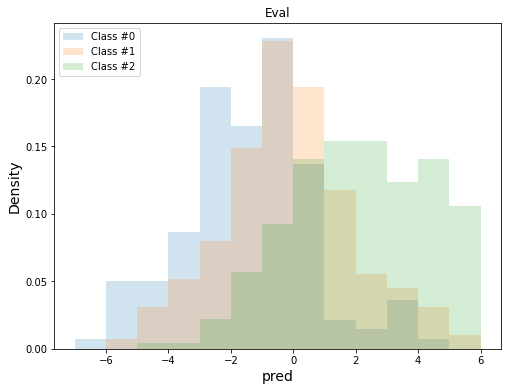

In [20]:
eval_df = pd.DataFrame()
eval_df['contrast_preds'] = contrast_preds
eval_df['contrast_targs'] = contrast_targs

label_list = [i for i in range(5)]
mean_list = []

plt.figure(figsize=(8,6))


for label_class in label_list:
    class_df = eval_df.loc[eval_df['contrast_targs'] == label_class]
    print("label_class: ", label_class)
    if len(class_df) == 0:
        print("no sample for this class")
        continue
    class_pred_list = class_df['contrast_preds'].tolist()
    class_mean_pred = np.mean(class_pred_list)
    mean_list.append(class_mean_pred)
    print("min: ", np.min(class_pred_list))
    print("mean: ", np.mean(class_pred_list))
    print("median: ", np.median(class_pred_list))
    print("max: ", np.max(class_pred_list))
    print("std: ", np.std(class_pred_list))
    plt.hist(class_pred_list, density=True, label='Class #{}'.format(label_class), bins=[i for i in range(-7, 7)], alpha=0.2)

plt.xlabel("pred", size=14)
plt.ylabel("Density", size=14)
plt.title("Eval")
plt.legend(loc='upper left')


mean_diffs = []
prev_mean = None
for class_mean in mean_list:
    if prev_mean == None:
        prev_mean = class_mean
        continue
    else:
        mean_diff = class_mean - prev_mean
        mean_diffs.append(mean_diff)
        prev_mean = class_mean
        
print("mean_diffs: ", mean_diffs)

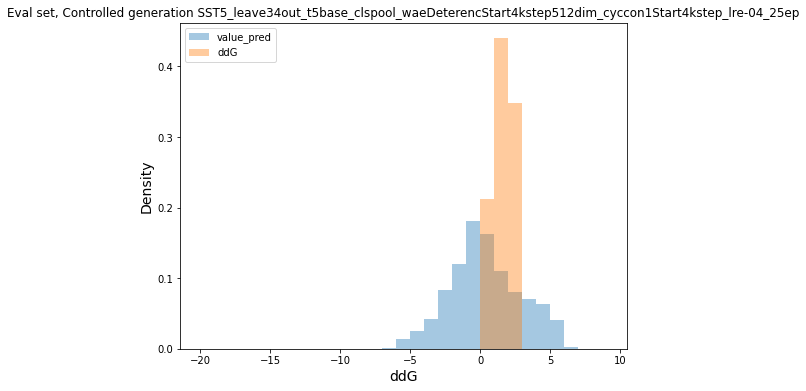

In [21]:
plt.figure(figsize=(8,6))
plt.hist(contrast_preds, density=True, label='value_pred', bins=[i for i in range(-20, 10)], alpha=0.4)


plt.hist(contrast_targs, density=True, label='ddG', bins=[i for i in range(-20, 10)], alpha=0.4)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("Eval set, Controlled generation SST5_leave34out_t5base_clspool_waeDeterencStart4kstep512dim_cyccon1Start4kstep_lre-04_25ep")
plt.legend(loc='upper left')

In [22]:
eval_df = pd.DataFrame()

In [23]:
eval_df['value_pred'] = contrast_preds
eval_df['ddG'] = contrast_targs

In [24]:
eval_df = eval_df.sort_values(by='value_pred', ascending=True)

In [25]:
# topK_list = [10, 100, 1000, 10000]
percentile_list = [95, 90, 85, 80, 75]
topK_list = [len(eval_df)*(100-i)//100 for i in percentile_list]
print(topK_list)

[32, 65, 98, 131, 164]


In [26]:
ddG_df = eval_df
all_ddG_list = eval_df['ddG']

In [27]:
for topK in topK_list:
    topK_df = ddG_df[:topK]
    print("top K: ", len(topK_df))
    print("max: ", np.max(topK_df['ddG']))
    print("min: ", np.min(topK_df['ddG']))
    print("mean: ", np.mean(topK_df['ddG']))
    print("median: ", np.median(topK_df['ddG']))
    
    for percentile in percentile_list:
        pct = np.percentile(all_ddG_list, 100-percentile)
        PCI_pct = np.sum(topK_df['ddG'] < pct) / len(topK_df['ddG'])
        print("PCI_{}pct: ".format(percentile), PCI_pct)
    
    PCI_WT = np.sum(topK_df['ddG'] < 0) / len(topK_df['ddG'])
    print("PCI_WT: ", PCI_WT)
    
    print("_"*20)
    
tophalf_df = ddG_df[:len(ddG_df)//2]
print("top half: ", len(tophalf_df))
print("max: ", np.max(tophalf_df['ddG']))
print("min: ", np.min(tophalf_df['ddG']))
print("mean: ", np.mean(tophalf_df['ddG']))
print("median: ", np.median(tophalf_df['ddG']))


# PCI_75pct = np.sum(tophalf_df['ddG'] < train_75pct) / len(tophalf_df['ddG'])
# print("PCI_75pct: ", PCI_75pct)

for percentile in percentile_list:
    pct = np.percentile(all_ddG_list, 100-percentile)
    PCI_pct = np.sum(tophalf_df['ddG'] < pct) / len(tophalf_df['ddG'])
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(tophalf_df['ddG'] < 0) / len(tophalf_df['ddG'])
print("PCI_WT: ", PCI_WT)

print("_"*20)


# training data distribution
print("train dataset: ", len(all_ddG_list))
print("max: ", np.max(all_ddG_list))
print("min: ", np.min(all_ddG_list))
print("mean: ", np.mean(all_ddG_list))
print("median: ", np.median(all_ddG_list))


for percentile in percentile_list:
    pct = np.percentile(all_ddG_list, 100-percentile)
    PCI_pct = np.sum(all_ddG_list < pct) / len(all_ddG_list)
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(all_ddG_list < 0) / len(all_ddG_list)
print("PCI_WT: ", PCI_WT)

print("_"*20)

top K:  32
max:  2.0
min:  0.0
mean:  0.5
median:  0.0
PCI_95pct:  0.0
PCI_90pct:  0.0
PCI_85pct:  0.0
PCI_80pct:  0.0
PCI_75pct:  0.53125
PCI_WT:  0.0
____________________
top K:  65
max:  2.0
min:  0.0
mean:  0.5384615384615384
median:  1.0
PCI_95pct:  0.0
PCI_90pct:  0.0
PCI_85pct:  0.0
PCI_80pct:  0.0
PCI_75pct:  0.49230769230769234
PCI_WT:  0.0
____________________
top K:  98
max:  2.0
min:  0.0
mean:  0.5510204081632653
median:  0.0
PCI_95pct:  0.0
PCI_90pct:  0.0
PCI_85pct:  0.0
PCI_80pct:  0.0
PCI_75pct:  0.5102040816326531
PCI_WT:  0.0
____________________
top K:  131
max:  2.0
min:  0.0
mean:  0.6183206106870229
median:  1.0
PCI_95pct:  0.0
PCI_90pct:  0.0
PCI_85pct:  0.0
PCI_80pct:  0.0
PCI_75pct:  0.4580152671755725
PCI_WT:  0.0
____________________
top K:  164
max:  2.0
min:  0.0
mean:  0.676829268292683
median:  1.0
PCI_95pct:  0.0
PCI_90pct:  0.0
PCI_85pct:  0.0
PCI_80pct:  0.0
PCI_75pct:  0.42073170731707316
PCI_WT:  0.0
____________________
top half:  328
max:  2.0
min

# Get value_pred of train data

In [28]:
train_eval_output = evaluate(model, train_loader, do_mi=latent_space_args['do_mi'], return_pred=True,  latent_space_type=latent_space_args['latent_space_type'])
# eval_output = evaluate(model, eval_loader, do_mi=latent_space_args['do_mi'], return_pred=True, latent_space_type=latent_space_args['latent_space_type'])

100%|██████████| 309/309 [00:23<00:00, 13.00it/s]

target_array.shape:  (4934,)
prediction_array.shape:  (4934,)
spearmanr_value:  0.928635583479985


In [29]:
train_lm_loss, train_contrastive_loss, train_spearmanr_value = train_eval_output['lm_loss'], train_eval_output['contrastive_loss'], train_eval_output['spearmanr']

print("train_lm_loss: ", train_lm_loss)
print("train_contrastive_loss: ", train_contrastive_loss)
print("train_spearmanr_value: ", train_spearmanr_value)

train_lm_loss:  tensor(0.9177, device='cuda:0')
train_contrastive_loss:  tensor(0.0138, device='cuda:0')
train_spearmanr_value:  0.928635583479985


In [30]:
train_contrast_preds, train_contrast_targs = train_eval_output['contrast_preds'], train_eval_output['contrast_targs']

print("len(train_contrast_preds): ", len(train_contrast_preds))
print("len(train_contrast_targs): ", len(train_contrast_targs))

len(train_contrast_preds):  4934
len(train_contrast_targs):  4934


In [31]:
print("stats of contrast_preds, train set")
print("min: ", np.min(train_contrast_preds))
print("mean: ", np.mean(train_contrast_preds))
print("median: ", np.median(train_contrast_preds))
print("max: ", np.max(train_contrast_preds))
print("std: ", np.std(train_contrast_preds))

stats of contrast_preds, train set
min:  -6.9219007
mean:  0.28920713
median:  -0.18580833
max:  6.6132064
std:  3.4957438


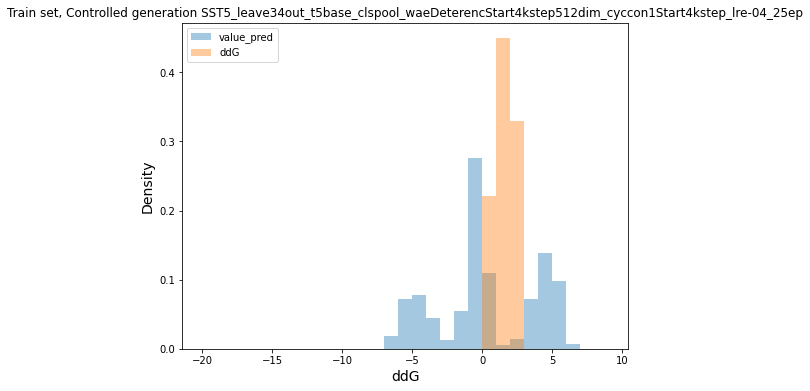

In [32]:
plt.figure(figsize=(8,6))
plt.hist(train_contrast_preds, density=True, label='value_pred', bins=[i for i in range(-20, 10)], alpha=0.4)


plt.hist(train_contrast_targs, density=True, label='ddG', bins=[i for i in range(-20, 10)], alpha=0.4)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("Train set, Controlled generation SST5_leave34out_t5base_clspool_waeDeterencStart4kstep512dim_cyccon1Start4kstep_lre-04_25ep")
plt.legend(loc='upper left')

label_class:  0
min:  -6.921900749206543
mean:  -4.694745743121857
median:  -4.704269170761108
max:  -1.6315938234329224
std:  0.9475917518107335
label_class:  1
min:  -4.97348165512085
mean:  -0.3653714493099399
median:  -0.3463742285966873
max:  2.8700761795043945
std:  0.6116788950165138
label_class:  2
min:  1.5053719282150269
mean:  4.534485381738893
median:  4.593065977096558
max:  6.613206386566162
std:  0.8379923118177243
label_class:  3
no sample for this class
label_class:  4
no sample for this class
mean_diffs:  [4.329374293811917, 4.899856831048833]


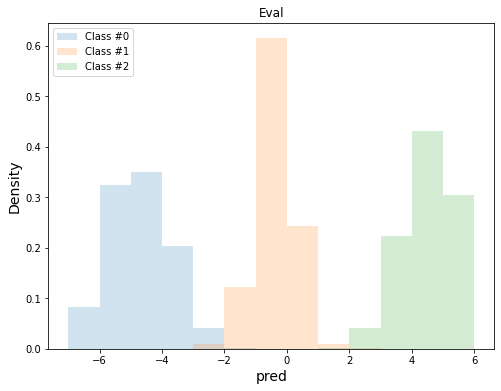

In [33]:
train_df = pd.DataFrame()
train_df['train_contrast_preds'] = train_contrast_preds
train_df['train_contrast_targs'] = train_contrast_targs

label_list = [i for i in range(5)]
mean_list = []

plt.figure(figsize=(8,6))


for label_class in label_list:
    class_df = train_df.loc[train_df['train_contrast_targs'] == label_class]
    print("label_class: ", label_class)
    if len(class_df) == 0:
        print("no sample for this class")
        continue
    class_pred_list = class_df['train_contrast_preds'].tolist()
    class_mean_pred = np.mean(class_pred_list)
    mean_list.append(class_mean_pred)
    print("min: ", np.min(class_pred_list))
    print("mean: ", np.mean(class_pred_list))
    print("median: ", np.median(class_pred_list))
    print("max: ", np.max(class_pred_list))
    print("std: ", np.std(class_pred_list))
    plt.hist(class_pred_list, density=True, label='Class #{}'.format(label_class), bins=[i for i in range(-7, 7)], alpha=0.2)

plt.xlabel("pred", size=14)
plt.ylabel("Density", size=14)
plt.title("Eval")
plt.legend(loc='upper left')


mean_diffs = []
prev_mean = None
for class_mean in mean_list:
    if prev_mean == None:
        prev_mean = class_mean
        continue
    else:
        mean_diff = class_mean - prev_mean
        mean_diffs.append(mean_diff)
        prev_mean = class_mean
        
print("mean_diffs: ", mean_diffs)